In [1]:

from sklearn import datasets
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.utils import shuffle
data = datasets.load_breast_cancer()
from sklearn.preprocessing import StandardScaler

import jax.numpy as jnp
from jax import grad as fgrad
from jax import jit, vmap, jacfwd, jacrev, device_put
import numpy as np
from numpy.linalg import norm
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.autograd import grad
from scipy.integrate import solve_ivp
np.set_printoptions(suppress=True)
from matplotlib import pyplot as plt
import random
import jax

from copy import deepcopy

CUDA = torch.cuda.is_available()
mse = nn.MSELoss(reduction='none')
NUMERICAL_METHOD = 'RK45'

seed = 23

random.seed(seed)
# Set seed for NumPy
np.random.seed(seed)
# Set seed for PyTorch
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU
# Set seed for JAX
key = jax.random.PRNGKey(seed)

def select_n_points(data_X, data_y, n):
    # Check if n is even
    if n % 2 != 0:
        raise ValueError("n must be an even number to select equal points from both classes.")

    # Separate the data into two classes: +1 and -1
    class_pos = data_X[data_y == 1]  # Class +1
    class_neg = data_X[data_y == -1]  # Class -1

    # Check if enough points exist in both classes
    if len(class_pos) < n // 2 or len(class_neg) < n // 2:
        raise ValueError("Not enough data points in one or both classes to select n points.")

    # Randomly select n//2 points from each class
    selected_pos = class_pos[np.random.choice(len(class_pos), n // 2, replace=False)]
    selected_neg = class_neg[np.random.choice(len(class_neg), n // 2, replace=False)]

    # Combine the selected points and their labels
    selected_X = np.vstack((selected_pos, selected_neg))
    selected_y = np.hstack((np.ones(n // 2), -np.ones(n // 2)))

    # Shuffle the selected points and labels
    selected_X, selected_y = shuffle(selected_X, selected_y, random_state=42)

    return selected_X, selected_y

In [2]:
X = data.data 
y = data.target
feature_names = data.feature_names

X = pd.DataFrame(X, columns=feature_names) 
# Select only the desired features
data_X = X[['mean radius', 'mean concave points']].to_numpy()

# Encode y to be +1 and -1
le = LabelEncoder()
data_y = le.fit_transform(y)
data_y[data_y == 0] = -1  # Replace 0 with -1

[Text(0.5, 0, 'mean radius'), Text(0, 0.5, 'mean concave points')]

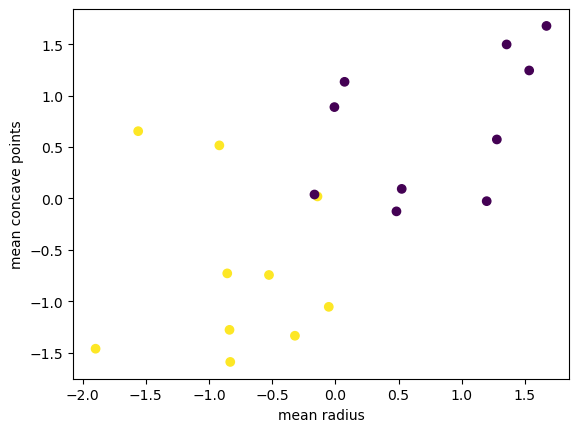

In [3]:
n = 20
selected_X, selected_y = select_n_points(data_X, data_y, n)
scaler = StandardScaler()
selected_X = scaler.fit_transform(selected_X)
_, ax = plt.subplots()
scatter = ax.scatter(selected_X[:, 0], selected_X[:, 1], c=selected_y)
ax.set(xlabel='mean radius', ylabel='mean concave points')

In [4]:
# Define the plotting function
def plot_svm_decision_boundary(X, y, w, b, feature_x_idx, feature_y_idx):
    plt.figure(figsize=(8, 6))
    
    # Plot the two classes
    plt.scatter(X[y > 0][:, feature_x_idx], X[y > 0][:, feature_y_idx], c='b', label='Malignant')
    plt.scatter(X[y < 0][:, feature_x_idx], X[y < 0][:, feature_y_idx], c='r', label='Benign')

    # Plot decision boundary
    x_min, x_max = X[:, feature_x_idx].min() - 1, X[:, feature_x_idx].max() + 1
    y_min, y_max = X[:, feature_y_idx].min() - 1, X[:, feature_y_idx].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    # Use only the selected features for the decision boundary
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = np.dot(grid, w[[feature_x_idx, feature_y_idx]]) + b
    Z = Z.reshape(xx.shape)
    
    plt.contour(xx, yy, Z, colors='k', levels=[0], alpha=0.5, linestyles=['-'])
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 1], alpha=0.5, linestyles=['--'])
    
    plt.xlabel(f'mean radius')
    plt.ylabel(f'mean concave points')
    plt.legend()
    #plt.title('Soft Margin SVM Decision Boundary')
    plt.show()
    
# Define the modified plotting function to plot two decision boundaries
def plot_svm_decision_boundary_confrontation(X, y, w_1, b_1, w_2, b_2, feature_x_idx, feature_y_idx):
    plt.figure(figsize=(8, 6))
    
    # Plot the two classes
    plt.scatter(X[y > 0][:, feature_x_idx], X[y > 0][:, feature_y_idx], c='b', label='Malignant')
    plt.scatter(X[y < 0][:, feature_x_idx], X[y < 0][:, feature_y_idx], c='r', label='Benign')

    # Create mesh grid for decision boundaries
    x_min, x_max = X[:, feature_x_idx].min() - 1, X[:, feature_x_idx].max() + 1
    y_min, y_max = X[:, feature_y_idx].min() - 1, X[:, feature_y_idx].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # First model's decision boundary (Ground Truth) in orange with highlight effect (thicker and transparent)
    Z1 = np.dot(grid, w_1[[feature_x_idx, feature_y_idx]]) + b_1
    Z1 = Z1.reshape(xx.shape)
    ground_truth = plt.contour(xx, yy, Z1, colors='purple', levels=[0], alpha=0.3, linewidths=5, linestyles=['-'])
    plt.contour(xx, yy, Z1, colors='purple', levels=[-1, 1], alpha=0.3, linewidths=3, linestyles=['--'])
    
    # Second model's decision boundary (ODE Solution) in purple
    Z2 = np.dot(grid, w_2[[feature_x_idx, feature_y_idx]]) + b_2
    Z2 = Z2.reshape(xx.shape)
    ode_solution = plt.contour(xx, yy, Z2, colors='green', levels=[0], alpha=0.8, linewidths=2, linestyles=['-'])
    plt.contour(xx, yy, Z2, colors='green', levels=[-1, 1], alpha=0.8, linewidths=1.5, linestyles=['--'])
    
    # Add the two main lines to the legend
    h1, _ = ground_truth.legend_elements()
    h2, _ = ode_solution.legend_elements()
    legend_elements = [h1[0], h2[0], 
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=10),
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10)]
    legend_labels = ['CVX Solution', 'ODE Solution', 'Malignant', 'Benign']
    plt.legend(legend_elements, legend_labels, loc='upper right')
    
    # Add labels, title, and show the plot
    plt.xlabel(f'mean radius')
    plt.ylabel(f'mean concave points')
    #plt.title('SVM Decision Boundaries')
    plt.show()
    
def plot_svm_decision_boundary_confrontation_PINN(X, y, w_1, b_1, w_2, b_2, feature_x_idx, feature_y_idx):
    plt.figure(figsize=(8, 6))
    
    # Plot the two classes
    plt.scatter(X[y > 0][:, feature_x_idx], X[y > 0][:, feature_y_idx], c='b', label='Malignant')
    plt.scatter(X[y < 0][:, feature_x_idx], X[y < 0][:, feature_y_idx], c='r', label='Benign')

    # Create mesh grid for decision boundaries
    x_min, x_max = X[:, feature_x_idx].min() - 1, X[:, feature_x_idx].max() + 1
    y_min, y_max = X[:, feature_y_idx].min() - 1, X[:, feature_y_idx].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # First model's decision boundary (Ground Truth) in orange with highlight effect (thicker and transparent)
    Z1 = np.dot(grid, w_1[[feature_x_idx, feature_y_idx]]) + b_1
    Z1 = Z1.reshape(xx.shape)
    ground_truth = plt.contour(xx, yy, Z1, colors='purple', levels=[0], alpha=0.3, linewidths=5, linestyles=['-'])
    plt.contour(xx, yy, Z1, colors='purple', levels=[-1, 1], alpha=0.3, linewidths=3, linestyles=['--'])
    
    # Second model's decision boundary (ODE Solution) in purple
    Z2 = np.dot(grid, w_2[[feature_x_idx, feature_y_idx]]) + b_2
    Z2 = Z2.reshape(xx.shape)
    ode_solution = plt.contour(xx, yy, Z2, colors='green', levels=[0], alpha=0.8, linewidths=2, linestyles=['-'])
    plt.contour(xx, yy, Z2, colors='green', levels=[-1, 1], alpha=0.8, linewidths=1.5, linestyles=['--'])
    
    # Add the two main lines to the legend
    h1, _ = ground_truth.legend_elements()
    h2, _ = ode_solution.legend_elements()
    legend_elements = [h1[0], h2[0], 
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=10),
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10)]
    legend_labels = ['ODE Solution', 'PINN Solution', 'Malignant', 'Benign']
    plt.legend(legend_elements, legend_labels, loc='upper right')
    
    # Add labels, title, and show the plot
    plt.xlabel(f'mean radius')
    plt.ylabel(f'mean concave points')
    #plt.title('SVM Decision Boundaries')
    plt.show()

In [5]:
def adjust_label_positions(positions, min_distance=0.02):
    """Adjust vertical positions of labels to avoid overlap."""
    sorted_positions = sorted(enumerate(positions), key=lambda x: x[1])
    adjusted_positions = positions.copy()
    
    for i in range(1, len(sorted_positions)):
        curr_idx, curr_pos = sorted_positions[i]
        prev_idx, prev_pos = sorted_positions[i-1]
        
        if curr_pos - prev_pos < min_distance:
            adjusted_positions[curr_idx] = prev_pos + min_distance
    
    return adjusted_positions

def plot_ode_system(t_values, y_values):
    plt.figure(figsize=(8, 6))
    # Enable LaTeX rendering
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    # Plot each line and prepare label information
    labels = [f'w_{i}' for i in range(1,3)] + ['b']
    colors = plt.cm.rainbow(np.linspace(0, 1, len(labels)))
    label_positions = []

    for i, (label, color) in enumerate(zip(labels, colors)):
        line = plt.plot(t_values, y_values[i, :], label=label, color=color)[0]
        label_positions.append(y_values[i, -1])

    # Adjust label positions
    y_min, y_max = np.min(y_values), np.max(y_values)
    y_range = y_max - y_min
    min_distance = 0.02 * y_range  # 2% of y-range as minimum distance
    adjusted_positions = adjust_label_positions(label_positions, min_distance)

    # Add adjusted labels with increased font size and space
    fontsize = 14  # Adjust the font size here
    x_offset = 1  # Space to move the label away from the line
    
    for i, (label, color, position) in enumerate(zip(labels[:3], colors[:3], adjusted_positions[:3])):
        math_label = f"${label}$"  # Add space with LaTeX's \quad
        x_end = t_values[-1]
        plt.text(x_end + x_offset, position, f' {math_label}', verticalalignment='center', 
                 horizontalalignment='left', color=color, fontsize=fontsize)

    plt.xlabel('Time', fontsize=fontsize)
    plt.ylabel('y(t)', fontsize=fontsize)
    plt.title('ODE System Solution', fontsize=fontsize)
    plt.grid(False)

    # Adjust the plot limits to make room for labels
    plt.xlim(t_values[0], t_values[-1] * 1.1)  # Extend x-axis by 10%
    plt.ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)  # Extend y-axis by 10% on both ends

    plt.tight_layout()
    plt.show()

In [6]:
def hyperplane_similarity(w, b, w_opt, b_opt, alpha=0.5, beta=0.5):
    """
    Computes a metric to measure the similarity between two hyperplanes defined by (w, b) and (w_opt, b_opt).
    
    Parameters:
    - w (np.ndarray): Normal vector of the first hyperplane.
    - b (float): Offset of the first hyperplane.
    - w_opt (np.ndarray): Normal vector of the optimal hyperplane.
    - b_opt (float): Offset of the optimal hyperplane.
    - alpha (float): Weight for the angular difference metric. Default is 0.5.
    - beta (float): Weight for the offset difference metric. Default is 0.5.
    
    Returns:
    - float: Combined metric value. Closer to 0 indicates more similar hyperplanes.
    """
    # Normalize vectors for angle computation
    norm_w = np.linalg.norm(w)
    norm_w_opt = np.linalg.norm(w_opt)
    
    # Handle edge cases for zero vectors
    if norm_w == 0 or norm_w_opt == 0:
        raise ValueError("The normal vector of a hyperplane cannot be a zero vector.")
    
    # Compute cosine similarity and angle metric
    cos_theta = np.dot(w, w_opt) / (norm_w * norm_w_opt)
    angle_metric = 1 - cos_theta
    
    # Normalize vectors to unit length for offset comparison
    w_unit = w / norm_w
    w_opt_unit = w_opt / norm_w_opt
    
    # Compute the offset difference metric
    offset_diff = abs(b / norm_w - b_opt / norm_w_opt)
    offset_metric = offset_diff / max(abs(b / norm_w), abs(b_opt / norm_w_opt), 1)
    
    # Combine metrics
    combined_metric = alpha * angle_metric + beta * offset_metric
    return combined_metric

# CVX

Time: 0.01414942741394043
Optimal objective value: 22.63453163455317
SCS solver iterations: 225
SCS solve time: 0.001506103
SCS setup time: 0.001758863
Optimal w:  [-1.90879094 -1.05297519]
Optimal b:  [-0.20938658]
Dual variables (Lagrange multipliers): [ 0.          2.505326    0.          0.          0.          1.57592649
  0.         10.00000012  9.99999993  0.          0.          0.
  0.92939902  0.          0.          0.          0.          0.
  0.          0.        ]
Constraints: [-0.5770188   0.0000009  -0.309607   -0.80719393 -1.7351696  -0.00000056
 -0.54229206  0.9600763   1.0657649  -3.4476917  -2.2528636  -3.9516857
 -0.00000082 -1.4677304  -2.0521905  -0.1302394  -1.1911539  -4.164977
 -3.3732624  -1.0808289  -0.00000006 -0.00000037  0.         -0.00000006
 -0.00000005  0.00000021 -0.00000001 -0.96007603 -1.0657651   0.00000002
  0.00000003 -0.00000004  0.00000031  0.00000003 -0.00000004  0.00000008
 -0.00000005  0.00000001  0.00000002 -0.00000005]


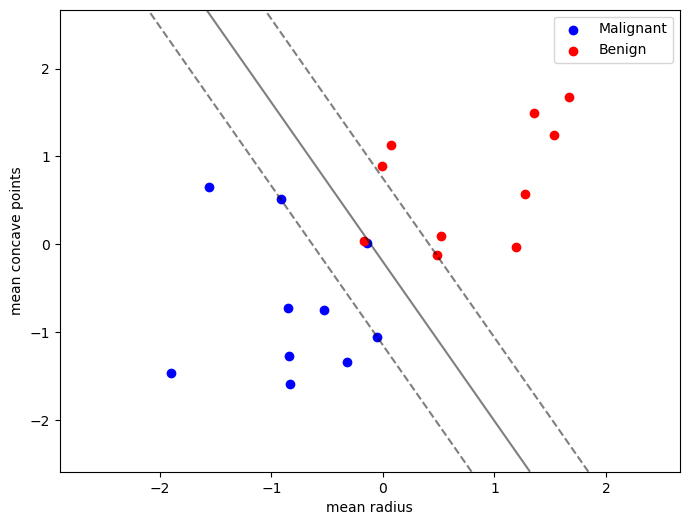

In [7]:
import cvxpy as cp
import numpy as np
import time

C = 10

num_features = selected_X.shape[1]

w = cp.Variable(num_features)
b = cp.Variable(1)
xi = cp.Variable(selected_y.shape[0])

objective = cp.Minimize((1/2)*cp.norm(w, 2)**2 + C * cp.sum(xi))

constraints = [
    cp.multiply(selected_y, cp.matmul(selected_X, w) + b) >= 1 - xi,
    xi >= 0
]

problem = cp.Problem(objective, constraints)

t0 = time.time()
problem.solve(solver='SCS')
solve_time = time.time() - t0

# Get solver stats
solver_stats = problem.solver_stats
print('Time:', solve_time)
print('Optimal objective value:', problem.value)
print('SCS solver iterations:', solver_stats.num_iters)
print('SCS solve time:', solver_stats.solve_time)
print('SCS setup time:', solver_stats.setup_time)

# Get the values of the variables
print('Optimal w: ', w.value)
print('Optimal b: ', b.value)

# Get the dual variables
dual_variables = constraints[0].dual_value
print('Dual variables (Lagrange multipliers):', dual_variables)

g_1 = [-selected_y[i] * (w.value @ selected_X[i] + b.value) + 1 for i in range(selected_y.shape[0])]
g_2 = [np.array([-xi.value[i]]) for i in range(selected_y.shape[0])]
g_SCS = jnp.array(g_1 + g_2).flatten()
print('Constraints:', g_SCS)

# Plotting
plot_svm_decision_boundary(selected_X, selected_y, w.value, b.value, 0, 1)

wb_cvx = np.concatenate([w.value, b.value])

# ODE

In [8]:
nw = selected_X.shape[1]
nb = 1
nxi = selected_y.shape[0]
nx = nw + nb + nxi
nu = selected_X.shape[0] * 2
NY = nx+nu

def f(x):
    w = x[:nw]
    b = x[nw]
    xi = x[nw+nb:]
    
    output = (1/2) * jnp.linalg.norm(w, 2)**2 + C * jnp.sum(xi)
    return output

def g(x):
    w = x[:nw]
    b = x[nw]
    xi = x[nw+nb:]
    
    g_1 = [-selected_y[i] * (w @ selected_X[i] + b) + 1 - xi[i] for i in range(selected_y.shape[0])]
    g_2 = [- xi[i] for i in range(selected_y.shape[0])]
    output = jnp.array(g_1 + g_2)
    return output

df = fgrad(f) # jacobian of f
dg = jacrev(g) # jacobian of g

def P(xu): # projection mapping
    return xu

def ODE(t, xu):
    x, u = xu[:nx].reshape((nx, )), xu[nx:].reshape((nu, ))

    dx = df(x) + dg(x).T@jnp.clip(u+g(x), a_min=0)
    dx = -dx
    du = -u + jnp.clip(u+g(x), a_min=0)
    du = 0.5*du
    dxu = jnp.concatenate([dx, du], axis=0)
    return dxu

ODE = jit(ODE)


In [9]:

def evalutation(xu): # metric OuC(x_pred): check if inisde feasable region and return the objective value
    "return  f(x),    if g(x)<=0, f(x)=np.inf, if g(x)>0 "
    x, u= xu[:nx], xu[nx:]
    if (g(x)<=0.01).all():
        obj = f(x)
        #print('g(x) values:', g(x))
    else:
        obj = np.inf
        #print('g(x) values:', g(x))
    return obj

def evaluation_plus(xu):
    x, u= xu[:nx], xu[nx:]
    lim = None
    if (g(x)<=0.001).all():
        lim = 0.001
    elif (g(x)<=0.01).all():
        lim = 0.01
    elif (g(x)<=0.1).all():
        lim = 0.1
    elif (g(x)<=1).all():
        lim = 1
    return f(x), lim


In [10]:
def solve_ODE(xuv0, T):
    t0 = time.time()
    sol = solve_ivp(ODE, [0., T], xuv0, method=NUMERICAL_METHOD)
    solve_time = time.time() - t0
    print('Time:', solve_time)
    result = P(sol.y[:, -1])
    
    obj, lim = evaluation_plus(result)
    print("objective:", obj, "lim:", lim)
    
    print("objective:", obj)
    print("w: ", result[:nw], "b: ", result[nw])
    wb_ode = result[:nw+nb]
    similarity = hyperplane_similarity(result[:nw], result[nw], wb_cvx[:nw], wb_cvx[nw])
    print("hyperplane similarity:", similarity)
    print("Dual variables (alpha):", result[:nx])
    print("Constraints:",g(result[:nx]))
    
    return sol, result, obj, lim, similarity

# PINN

In [11]:
class FNN(nn.Module):
    def __init__(self, y0):
        self.y0 = torch.tensor(y0, dtype=torch.float)
        if CUDA:
            self.y0 = self.y0.cuda()
        super(FNN, self).__init__()
        self.linear1 = nn.Linear(1, NEURONS).cuda()
        self.linearL = []
        for _ in range(LAYERS-1):
            self.linearL.append(nn.Linear(NEURONS, NEURONS).cuda())
        self.linear2 = nn.Linear(NEURONS, NY).cuda()

    def forward(self, x):
        t = x.cuda()
        x = torch.tanh(self.linear1(x))
        for i in range(LAYERS-1):
            x = torch.tanh(self.linearL[i](x))
        x = self.linear2(x)
        x = self.y0 + (1 - torch.exp(-(t-0)))*x
        return x


class NN_NOP:
    def __init__(self, y0, time_range, P, ODE, C_epsilon): # P: projection mapping, ODE, C_epsilon: OuC metric
        self.y0 = np.array(y0)
        self.time_range = time_range # [0, 10]
        self.T = time_range[-1] # T=10
        self.P = P
        self.ODE = ODE
        self.C_epsilon = C_epsilon
        self.vODE = vmap(ODE, in_axes=(0, 0), out_axes=0)
        #self.numerical_method() # solve analyicallly the ODE

    def numerical_method(self):
        sol = solve_ivp(self.ODE, self.time_range, self.y0, method=NUMERICAL_METHOD)
        self.y_T_ODE = sol.y[:, -1] # get last value of the solution
        self.y_T_ODE = self.P(self.y_T_ODE) # project it
        self.y_T_ODE = np.array(self.y_T_ODE)
        self.epsilon_ODE = self.C_epsilon(self.y_T_ODE) # calculate OuC (f(x))

    def NN_method(self, weights=None, t_L=None):
        """
        train the nn, store the following four

        L_loss:  list, loss of batch during training
        L_epsilon: list, epsilon_best during training
        L_y_T: list, yT during training
        net_best:  the best neural network model during training
        """
        net = FNN(self.y0)
        if weights is not None:
            net.load_state_dict(weights.state_dict())
        if CUDA:
            net = net.cuda()
            
        optimizer = Adam(net.parameters(), lr=LR) # ========> 0.001 not looks good
        i = 0
        L_loss = []
        L_epsilon = []
        L_epsilon_curr = []
        L_y_T = []
        L_y_T_curr = []
        #L_y_iterations = []
        t0 = time.time()
        while True:
            # Update, L_epsilon, L_yT, net_best
            T = self.T*torch.ones((1, 1), dtype=torch.float)
            if CUDA:
                T = T.cuda()
            y_T = self.P_multiple(T, net) # get the output of the nn at T (last time)
            L_y_T_curr.append(y_T)

            epsilon_current = self.C_epsilon(y_T) # calculate OuC (f(x))
            L_epsilon_curr.append(epsilon_current)
            if i==0: # if first iteration
                epsilon_best = epsilon_current
                y_T_best = y_T
                #y_T_error = np.linalg.norm(self.y_T_ODE-y_T_best, ord=2)
                net_best = deepcopy(net)
                #L_y_iterations.append(self.y_iteration(net_best))
            # if i==10:
            #     L_y_iterations.append(self.y_iteration(net_best))
            # if i==20:
            #     L_y_iterations.append(self.y_iteration(net_best))
            # if i==ITERATIONS-1:
            #L_y_iterations.append(self.y_iteration(net_best)) # store the output of the best nn across the time
            if epsilon_current < epsilon_best:
                epsilon_best = epsilon_current
                y_T_best = y_T
                #y_T_error = np.linalg.norm(self.y_T_ODE-y_T_best, ord=2)
                net_best = deepcopy(net)
            L_epsilon.append(epsilon_best) # store the best OuC
            L_y_T.append(y_T_best) # store the best output of the nn at T

            # TRAIN MODEL
            # Prepare input t, torch.tensor (NBATCH, 1)
            if t_L is not None:
                t = t_L[i]
            else:
                t = np.random.uniform(0, self.T, (NBATCH, 1))
            t = torch.tensor(t, dtype=torch.float, requires_grad=True)
            if CUDA:
                t = t.cuda()
            # Learning, L_loss
            loss = self.loss_compute(t, net)
            loss.backward()
            L_loss.append(loss.item())
            optimizer.step()
            optimizer.zero_grad()
            # Monitor
            if i%100==0:
            # if i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]:
                #print(f'T: {self.T}, y_T_ODE: {self.y_T_ODE.round(4)}, epsilon_ODE: {self.epsilon_ODE :.4f},  Iteration: {i}, Loss: {loss.item() :.4f},  epsilon_best: {epsilon_best :.4f}, y_T: {y_T_best.round(4)}, ||y_T_ODE-y_T_best||_2: {y_T_error :.4f}')
                #print(f'T: {self.T}, Iteration: {i}, Loss: {loss.item() :.4f},  epsilon_best: {epsilon_best :.4f}, y_T: {y_T_best.round(4)}')
                pass
            i = i+1
            
            torch.cuda.empty_cache()
            
            if i >= 1000 and all(x < 0.01 for x in L_loss[-5:]):
                break
            
            if i==ITERATIONS:
                break

        curr_net = deepcopy(net)
        return L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, curr_net, L_loss, time.time()-t0, i

    def loss_compute(self, t, net):
        # nn output xu, torch.tensor (NBATCH, nxu)
        y = net(t)

        # => Get ODE derivatives
        # True dxu, torch.tensor (NBATCH, nxu)
        t_cpu = t.cpu().detach().numpy()
        y_cpu = y[:, :].cpu().detach().numpy()
        dy = self.vODE(t_cpu, y_cpu)
        dy = np.array(dy)
        
        dy = torch.tensor(dy, dtype=torch.float)
        if CUDA:
            dy = dy.cuda()

        # => Get NN derivatives (autograd)
        # Predicted pdxu, torch.tensor (NBATCH, nxu)
        pdy = []
        for j in range(NY): # for all outputs node (for all variables)
            # y[:, [j]]: outputs of the nn for the j-th variable (all t of the batch), t: inputs of the nn, grad_outputs: scale the gradients to facilitate the compuation of the jacobian, Craete_graph: to compute higer order derivatives
            pdyi = grad(y[:, [j]], t, grad_outputs=torch.ones_like(y[:, [j]]), create_graph=True)[0] # torch autograd shape [NBATCH, 1]
            pdy.append(pdyi)
        pdy = torch.cat(pdy, dim=1) # for makning it a tensor: [NBATCH, NY]
        #pdy = torch.cat(pdy, dim=1) # for makning it a tensor: [NBATCH, NY]

        # Compute loss, torch.tensor a float
        dynamics_loss = mse(dy, pdy) # [NBATCH, NY]
        dynamics_loss = torch.sum(dynamics_loss, axis=1) # [NBATCH]
        dynamics_loss = torch.exp(-WEIGTHING*(t / T).detach().reshape((-1, )))*dynamics_loss  # proprity smaller t
        dynamics_loss = torch.mean(dynamics_loss, axis=0)
        
        return dynamics_loss

    def P_multiple(self, t, net): # get the projection of the output of the nn (for multiple t)
        y = net(t)
        y = y.reshape((-1, )).cpu().detach().numpy()
        output = self.P(y)
        output = np.array(output)
        return output

    def y_iteration(self, net): # get the ODE system estiamtion across the time
        # For L_y
        t = torch.arange(0, self.T, 0.1).reshape((-1, 1))
        if CUDA:
            t = t.cuda()
        y = [self.P_multiple(t[i].reshape((1,1)), net) for i in range(t.shape[0])]
        y = torch.tensor(np.array(y)).cpu().detach().numpy()

        return y # [T, NY]

# Runs

In [12]:
def iteration(ip):
    xu0 = jnp.array(ip)
    y0 = ip
    
    # ODE Solution
    sol, result, obj, lim, similarity = solve_ODE(xu0, T)
    
    if lim == None:
        print('>>> Infeasible')
    else:
        print('>>> Feasible with epsilon:', lim, 'objective:', obj)

    print("hyperplane similarity:", similarity)
    if similarity < 0.01:
        print('>>> ODE Solution is accurate, last iteration')
        lastIter = True
    else:
        lastIter = False
        
    t_values = sol.t
    y_values = sol.y

    w_ode = result[:data_X.shape[1]]
    b_ode = result[data_X.shape[1]]

    plot_ode_system(t_values, y_values)

    plot_svm_decision_boundary_confrontation(selected_X, selected_y, w.value, b.value, w_ode, b_ode, 0, 1)
    
    example = NN_NOP(y0, [0, T], P, ODE, evalutation) # init
    L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, net_curr, L_loss, t, n_iter = example.NN_method() # train
    print('epsilon:', L_epsilon[-1], 'time:', t, 'iterations:', n_iter)
    
    # ------------ NN plots ------------ 
    plt.plot(L_epsilon, marker='o', linestyle='-', label='OuC metric best', markersize=1)
    plt.plot(L_epsilon_curr, marker='o', linestyle='-', label='OuC metric current', markersize=1)
    plt.xlabel('iteration')
    plt.ylabel('OuC metric')
    #plt.title(f'l={res_1["layers"]}, n={res_1["neurons"]}, lr={res_1["lr"]}')
    plt.legend()
    plt.grid(False)
    #plt.set_ylim(y_min, y_max)
    plt.xlim(0, ITERATIONS)

    plt.tight_layout()
    # Show the plot
    plt.show()
    
    print('Last losses:', L_loss[-10:])

    plt.plot(L_loss, label='Loss')
    plt.xlabel('iteration')
    plt.ylabel('Loss')
    #plt.title(f'l={res_1["layers"]}, n={res_1["neurons"]}, lr={res_1["lr"]}')
    plt.legend()
    plt.grid(False)
    #plt.set_ylim(y_min, y_max)
    plt.xlim(0, ITERATIONS)
    plt.tight_layout()
    # Show the plot
    plt.show()
    
    if n_iter != ITERATIONS and lastIter:
        print('>>> NN Solution is accurate, last iteration')
        net = net_curr
        lastIter = True
    else:
        lastIter = False
        net = net_curr
    
    res = net(torch.tensor([T]).cuda()).cpu().detach().numpy()
    plot_svm_decision_boundary_confrontation_PINN(selected_X, selected_y, w_ode, b_ode, res[:data_X.shape[1]], res[data_X.shape[1]], 0, 1)
    print('Variables:', res[:nx])
    print('Constraints:', g(res[:nx]))
    
    pinn_obj, lim_pin = evaluation_plus(res)
    
    print("objective pinn:", pinn_obj, "epsion pinn:", lim_pin)
    
    print("w: ", res[:nw], "b: ", res[nw])

    similarity_pinn = hyperplane_similarity(res[:nw], res[nw], wb_cvx[:nw], wb_cvx[nw])
    print("PINN hyperplane similarity:", similarity_pinn)
    
    return res, pinn_obj, lastIter

In [13]:
NBATCH = 512
WEIGTHING = 1
LAYERS = 2
NEURONS = 100
LR = 0.001
T = 20.0

>>>> ITERATION: 1


Time: 2.225705623626709


objective: 17.71201 lim: 1
objective: 17.71201
w:  [-1.95387241 -1.03458207] b:  -0.02138973935387097
hyperplane similarity: 0.04326126404008933
Dual variables (alpha): [-1.95387241 -1.03458207 -0.02138974  0.00001691  0.08052248 -0.00070436
  0.00044307  0.00049229 -0.08179913  0.00024261  0.38532804  1.21772022
  0.00049181  0.00049086  0.00049292 -0.11560633  0.00048077  0.00049303
  0.03585036  0.00048296  0.00049178  0.00049225  0.0003795 ]
Constraints: [-0.7750422   0.08338305 -0.14285721 -0.98551947 -1.9379432  -0.08917934
 -0.33695066  0.37999848  0.04421008 -3.3064394  -2.1124103  -4.198873
 -0.12328663 -1.3346802  -2.2489605   0.03859795 -1.4048213  -4.021931
 -3.2193077  -1.351608   -0.00001691 -0.08052248  0.00070436 -0.00044307
 -0.00049229  0.08179913 -0.00024261 -0.38532802 -1.2177203  -0.00049181
 -0.00049086 -0.00049292  0.11560633 -0.00048077 -0.00049303 -0.03585036
 -0.00048296 -0.00049178 -0.00049225 -0.0003795 ]
>>> Feasible with epsilon: 1 objective: 17.71201
hype

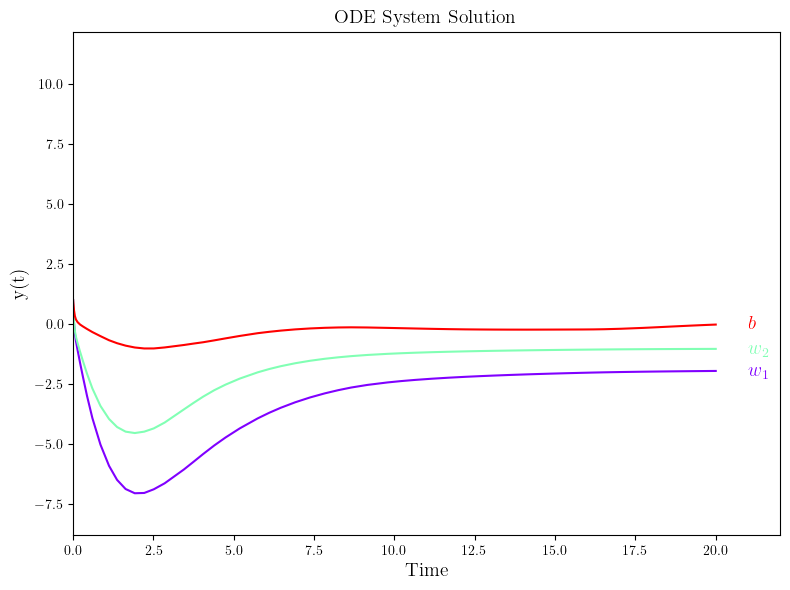

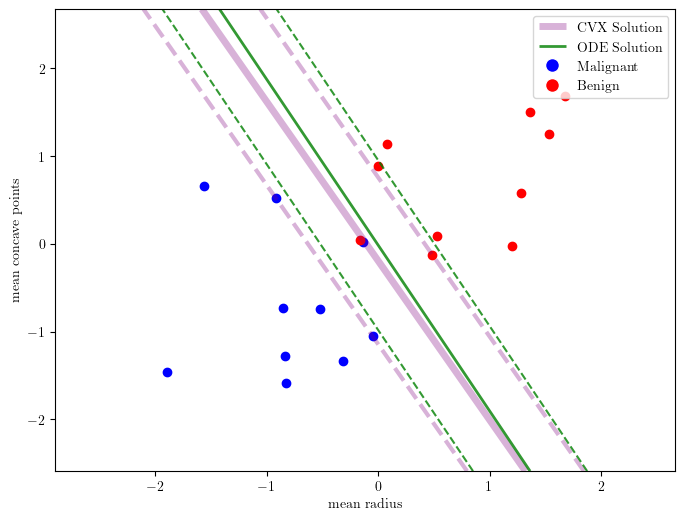

epsilon: 150.63963 time: 230.38453245162964 iterations: 2000


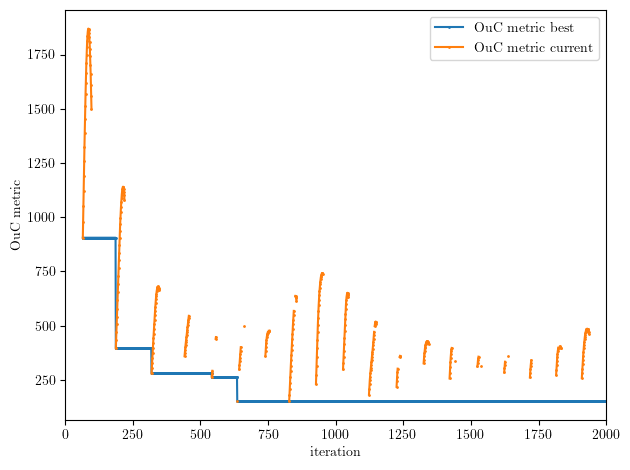

Last losses: [50.24814224243164, 51.803306579589844, 53.915985107421875, 55.70994567871094, 56.09998321533203, 57.00117492675781, 58.69916534423828, 58.280372619628906, 58.576866149902344, 59.01194763183594]


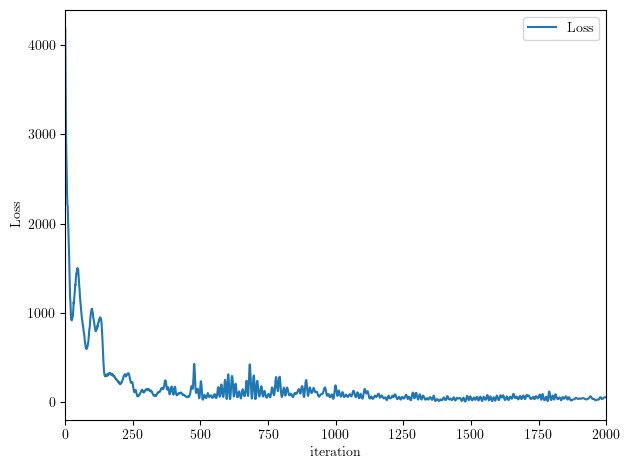

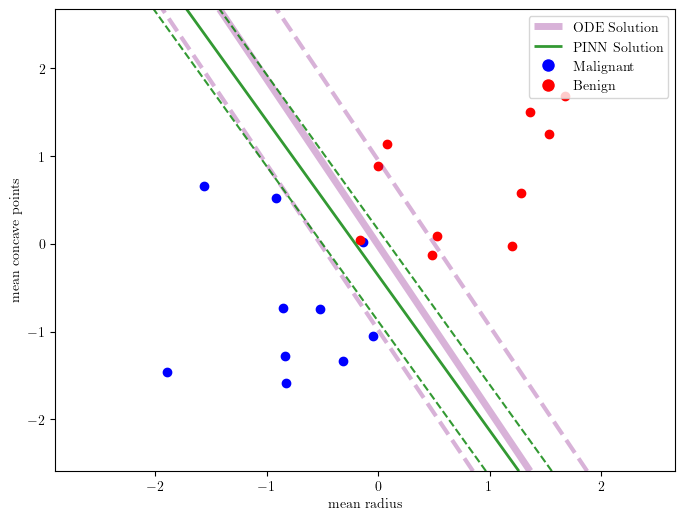

Variables: [-3.3847914  -1.9179742  -0.7016156  -0.16837966 -0.51141757 -0.35952464
  0.2594614   0.4366915   0.6217282  -0.17746302  1.9173234   1.9609096
  0.34447554  0.35117888  0.36226037 -0.12963384  0.46357182  0.3833654
  0.26505315  0.2869199   0.34217244  0.34632632 -0.7334728 ]
Constraints: [-1.3355409  -0.5858029  -1.2978063  -2.2015398  -4.0214033  -1.1181692
 -1.9453303  -0.656786   -1.1765689  -7.62492    -5.478821   -7.8867555
 -0.28710625 -4.1685038  -4.5460725  -1.6446953  -2.8790743  -8.91654
 -7.5076327  -1.5928426   0.16837966  0.51141757  0.35952464 -0.2594614
 -0.4366915  -0.6217282   0.17746302 -1.9173234  -1.9609096  -0.34447554
 -0.35117888 -0.36226037  0.12963384 -0.46357182 -0.3833654  -0.26505315
 -0.2869199  -0.34217244 -0.34632632  0.7334728 ]
objective pinn: 70.1832 epsion pinn: 1
w:  [-3.3847914 -1.9179742] b:  -0.7016156
PINN hyperplane similarity: 0.04217939895795711
>>>> ITERATION: 2


Time: 0.31302475929260254
objective: 22.755878 lim: 0.1
objective: 22.755878
w:  [-1.84884723 -0.98926521] b:  -0.19890489520349044
hyperplane similarity: 0.0006372848756791213
Dual variables (alpha): [-1.84884723 -0.98926521 -0.1989049  -0.00011805  0.01266781 -0.00003979
 -0.00012853 -0.00014548  0.03253415 -0.00012775  0.97861963  1.06019711
 -0.0001373  -0.00014474 -0.00013538  0.0082378  -0.00014007 -0.00014336
 -0.03475404 -0.00012237 -0.00014214 -0.00014181 -0.00009198]
Constraints: [-0.50848824  0.01880446 -0.26167735 -0.71332026 -1.6138949   0.02724874
 -0.45506975 -0.02180819  0.00859152 -3.2658336  -2.1290746  -3.7551925
  0.00344152 -1.3869871  -1.9114059  -0.02885876 -1.1038096  -3.9473188
 -3.1859848  -1.0393505   0.00011805 -0.01266781  0.00003979  0.00012854
  0.00014548 -0.03253415  0.00012775 -0.97861964 -1.0601971   0.0001373
  0.00014474  0.00013538 -0.0082378   0.00014007  0.00014336  0.03475404
  0.00012237  0.00014214  0.00014181  0.00009198]
>>> Feasible with ep

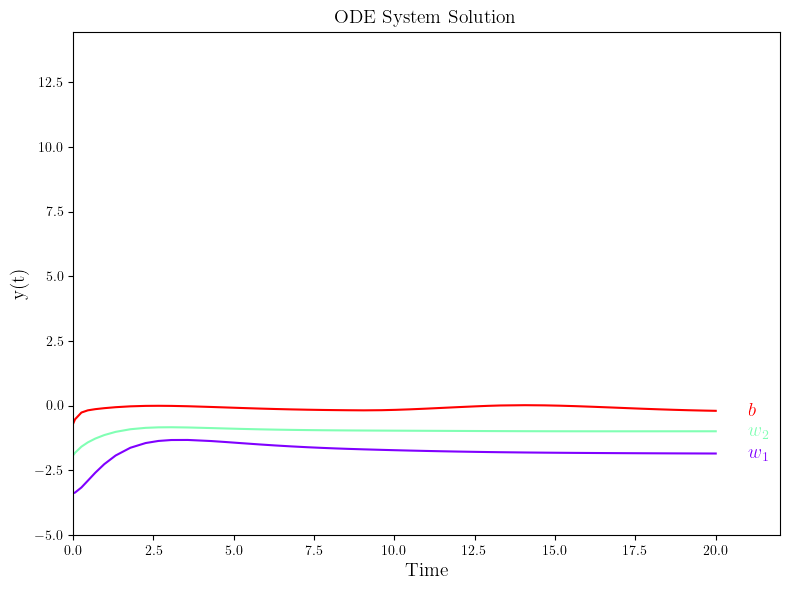

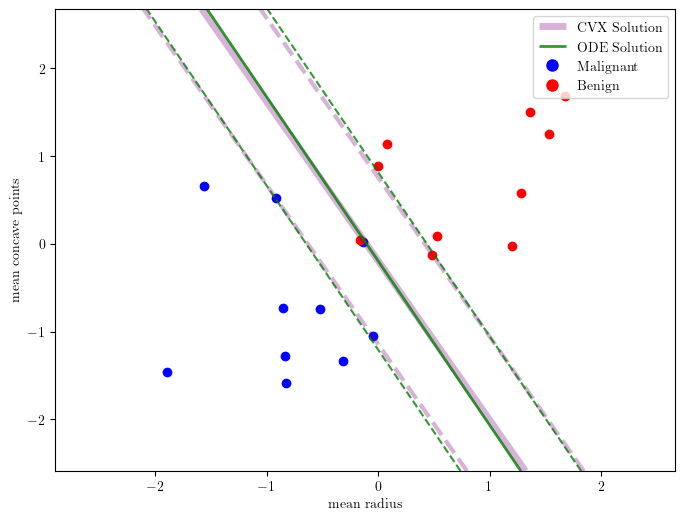

epsilon: 196.67738 time: 1189.5831699371338 iterations: 10000


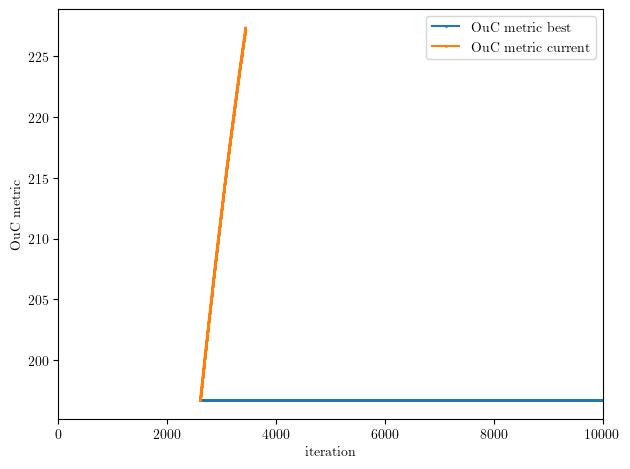

Last losses: [29.285388946533203, 29.424423217773438, 30.12972640991211, 30.095733642578125, 30.056610107421875, 30.136219024658203, 30.679750442504883, 29.879722595214844, 29.020355224609375, 28.95024871826172]


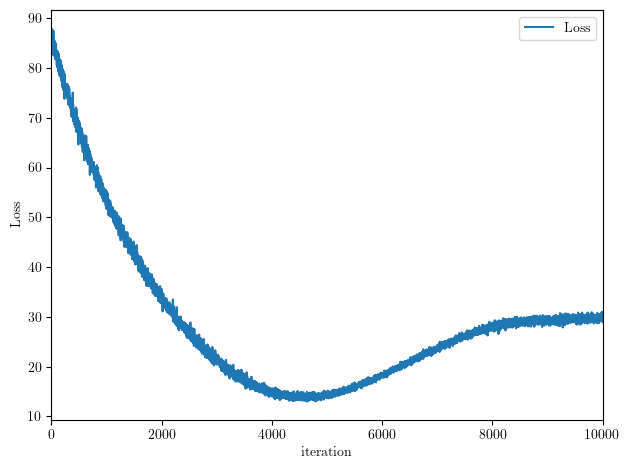

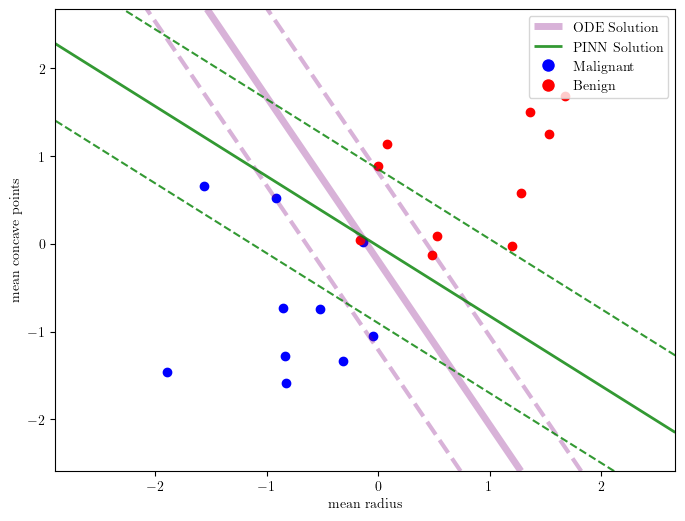

Variables: [-0.90818524 -1.1407541  -0.0334425   1.0886891   0.65541464 -0.2992903
  0.9150806   1.4729882  -0.23120403  1.7715902   0.23895311  0.5412214
  0.7598125   1.2041808   1.0480319  -0.05938029  1.3093622   1.3669397
 -0.4526971   1.2631364   0.9406912   1.2564341   1.8580158 ]
Constraints: [-1.3810986   0.01512255  0.6827273  -1.6949893  -2.6577144   0.01516624
 -2.1648252   0.68865806  0.53155285 -2.6060867  -2.05283    -3.4047146
  0.84765524 -1.4006109  -2.9020166   0.41268095 -1.8377886  -3.4052885
 -3.2291493  -1.4955454  -1.0886891  -0.65541464  0.2992903  -0.9150806
 -1.4729882   0.23120403 -1.7715902  -0.23895311 -0.5412214  -0.7598125
 -1.2041808  -1.0480319   0.05938029 -1.3093622  -1.3669397   0.4526971
 -1.2631364  -0.9406912  -1.2564341  -1.8580158 ]
objective pinn: 167.54277 epsion pinn: 1
w:  [-0.90818524 -1.1407541 ] b:  -0.033442497
PINN hyperplane similarity: 0.07492779566176813
>>>> ITERATION: 3


Time: 0.23140835762023926
objective: 22.617704 lim: 0.1
objective: 22.617704
w:  [-1.78634069 -0.97461122] b:  -0.16225693126010635
hyperplane similarity: 0.008162440949780879
Dual variables (alpha): [-1.78634069 -0.97461122 -0.16225693 -0.00000655  0.04877978 -0.04983244
  0.00003827  0.00003063  0.02284138 -0.00004531  0.93811569  1.08608775
  0.00002979  0.00002845  0.00004516  0.0160566   0.00002816  0.00001345
 -0.00755609  0.00002865  0.00004687  0.00002962 -0.00003285]
Constraints: [-0.5014979   0.04771427 -0.14105673 -0.7105622  -1.5796206   0.01900626
 -0.39734414 -0.0093918   0.00957312 -3.1152408  -2.0043147  -3.6519763
  0.00881324 -1.2760367  -1.8729143  -0.00687104 -1.0764394  -3.7818456
 -3.04285    -0.9880846   0.00000655 -0.04877978  0.04983244 -0.00003827
 -0.00003063 -0.02284138  0.00004531 -0.9381157  -1.0860877  -0.00002979
 -0.00002845 -0.00004516 -0.0160566  -0.00002816 -0.00001345  0.00755609
 -0.00002865 -0.00004687 -0.00002962  0.00003285]
>>> Feasible with ep

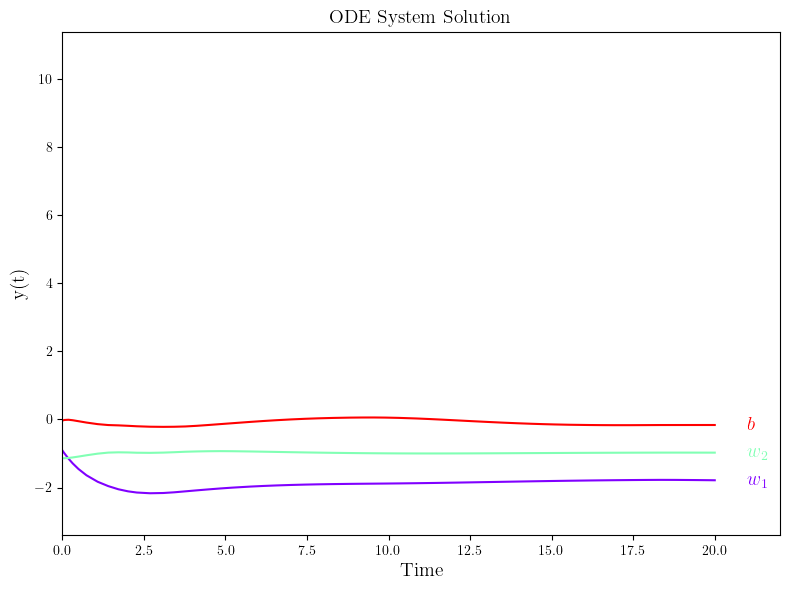

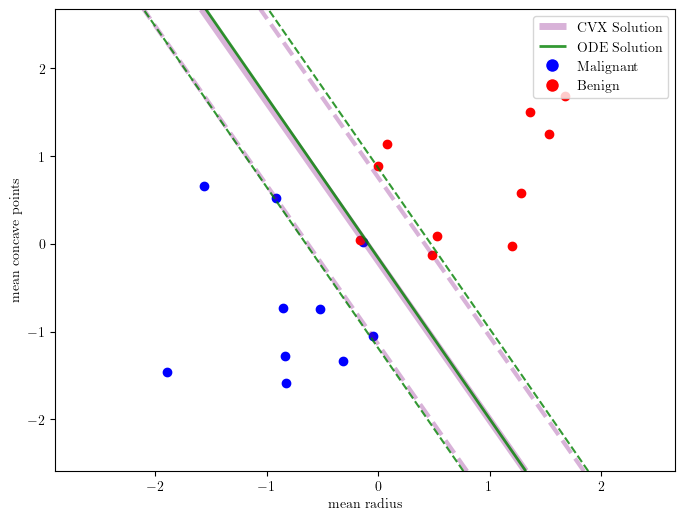

epsilon: inf time: 1143.904192686081 iterations: 10000


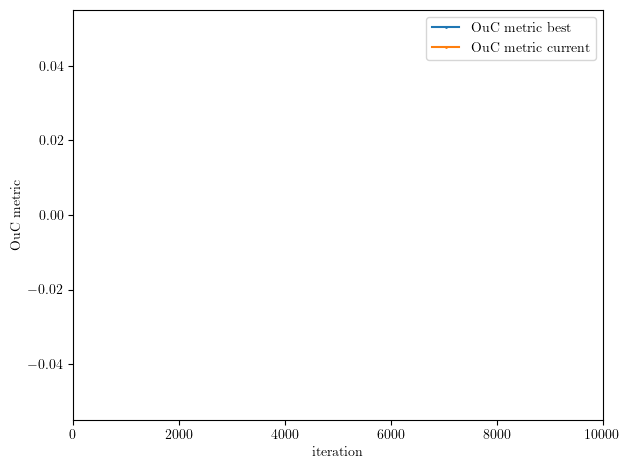

Last losses: [10.386964797973633, 10.706441879272461, 10.760537147521973, 10.382707595825195, 10.519527435302734, 10.248740196228027, 10.810773849487305, 10.5995512008667, 10.223373413085938, 10.495382308959961]


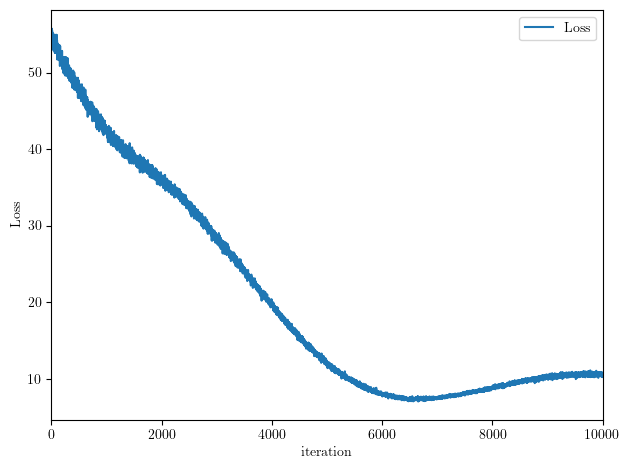

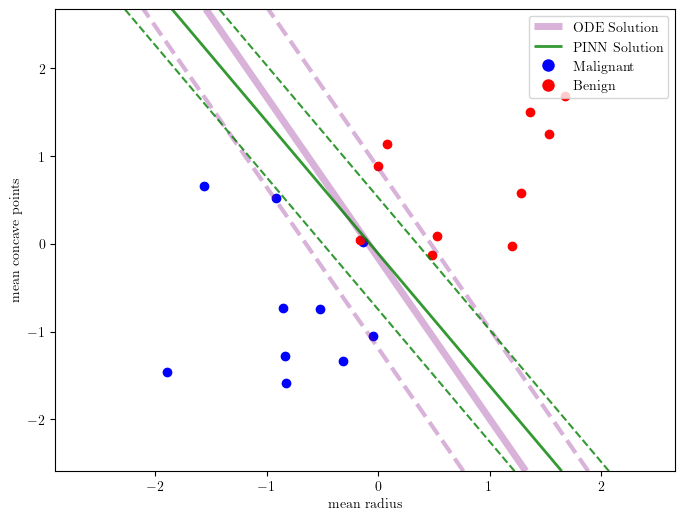

Variables: [-2.3615494  -1.5693302  -0.18076918 -1.0468495   0.0080359  -0.15160267
 -0.697602   -1.3549126  -0.3853448  -1.1734817   0.465049    1.2272512
 -0.53042245 -1.0796505  -1.3918749   0.06141242 -1.1250074  -0.64553535
 -0.3108822  -0.82716274 -1.0709376  -1.0885438  -0.48860574]
Constraints: [-0.18082625 -0.13355055 -0.41521022 -0.97235495 -1.4478372  -0.21102451
  0.04127905  0.41260335 -0.07789577 -4.225782   -2.0194917  -4.2020454
 -0.23927574 -0.8428206  -2.6325715  -0.24603707 -1.1561695  -4.688137
 -3.643023   -0.98959893  1.0468495  -0.0080359   0.15160267  0.697602
  1.3549126   0.3853448   1.1734817  -0.465049   -1.2272512   0.53042245
  1.0796505   1.3918749  -0.06141242  1.1250074   0.64553535  0.3108822
  0.82716274  1.0709376   1.0885438   0.48860574]
objective pinn: -112.046814 epsion pinn: None
w:  [-2.3615494 -1.5693302] b:  -0.18076918
PINN hyperplane similarity: 0.017845780003527018
>>>> ITERATION: 4


Time: 0.2683374881744385
objective: 22.759722 lim: 0.1
objective: 22.759722
w:  [-1.83488492 -0.98001467] b:  -0.1673378005844281
hyperplane similarity: 0.007849588483299794
Dual variables (alpha): [-1.83488492 -0.98001467 -0.1673378  -0.00000307  0.03454547 -0.00007161
 -0.00000186  0.0000553   0.01810935  0.00020281  0.92436993  1.10109181
 -0.00002278  0.00001211  0.00002415 -0.00653724  0.00001335 -0.00000293
 -0.01217816 -0.00000039 -0.00000688  0.00001747 -0.00000588]
Constraints: [-0.5259515   0.03408305 -0.22188626 -0.72819674 -1.6221465   0.02058412
 -0.4123273   0.00266711 -0.00268898 -3.2014518  -2.0745134  -3.7469056
 -0.00530342 -1.3390946  -1.9167954  -0.01175604 -1.1168118  -3.8770406
 -3.1218004  -1.0552647   0.00000307 -0.03454547  0.00007161  0.00000186
 -0.0000553  -0.01810935 -0.00020281 -0.92436993 -1.1010919   0.00002278
 -0.00001211 -0.00002415  0.00653724 -0.00001335  0.00000293  0.01217816
  0.00000039  0.00000688 -0.00001747  0.00000588]
>>> Feasible with epsi

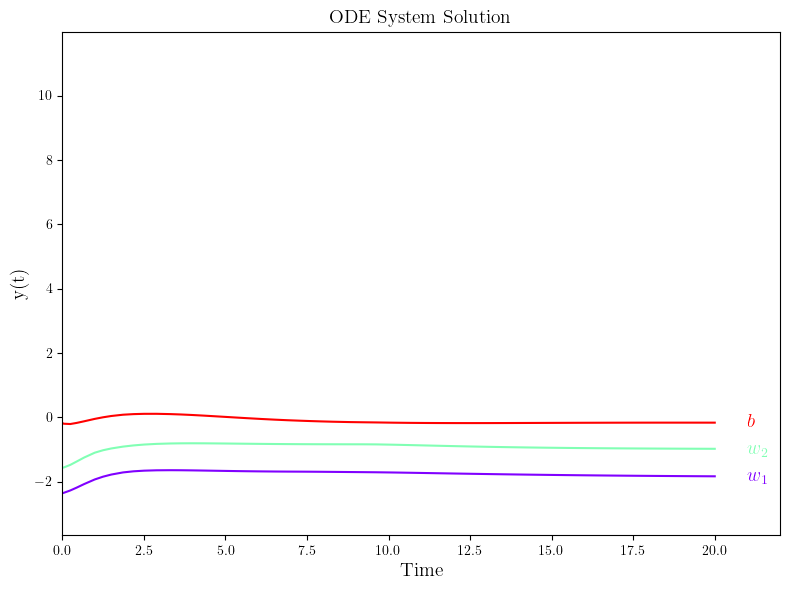

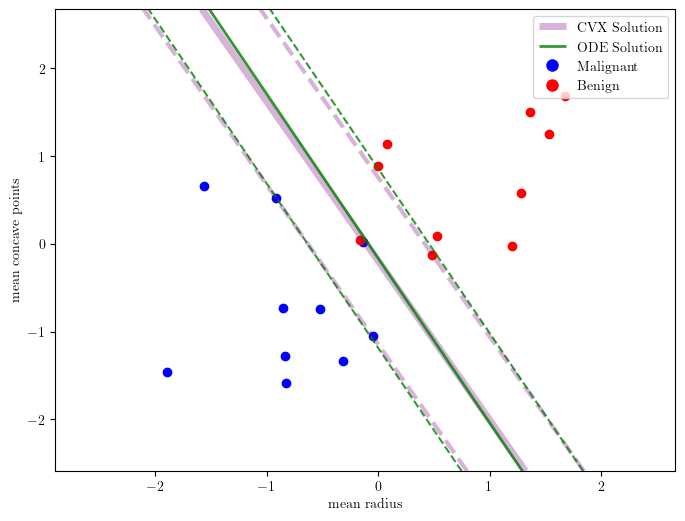

epsilon: inf time: 1131.2112135887146 iterations: 10000


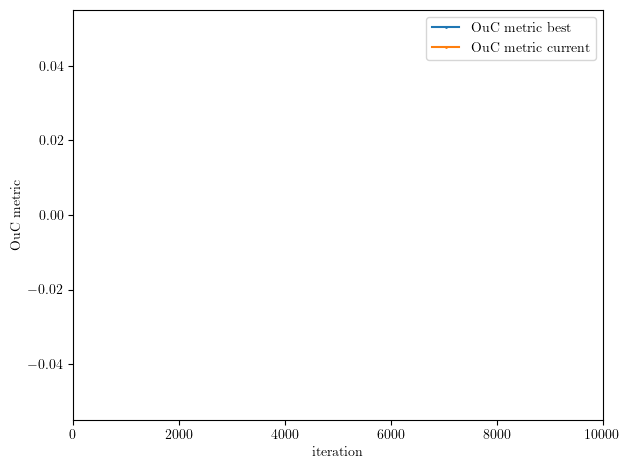

Last losses: [1.166298270225525, 1.2072163820266724, 1.2011991739273071, 1.1900992393493652, 1.1353297233581543, 1.1947381496429443, 1.1721774339675903, 1.170245885848999, 1.2213609218597412, 1.2547498941421509]


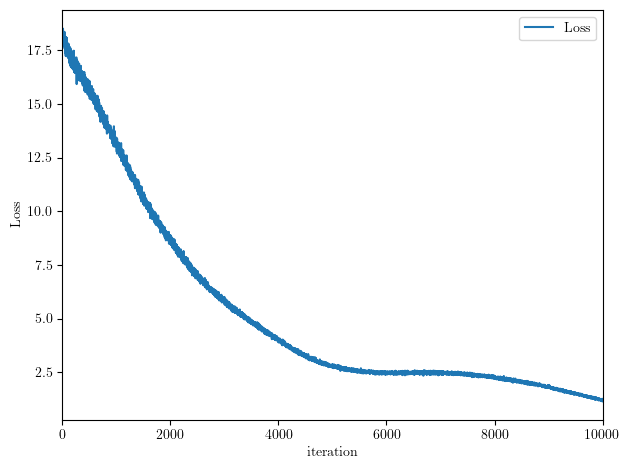

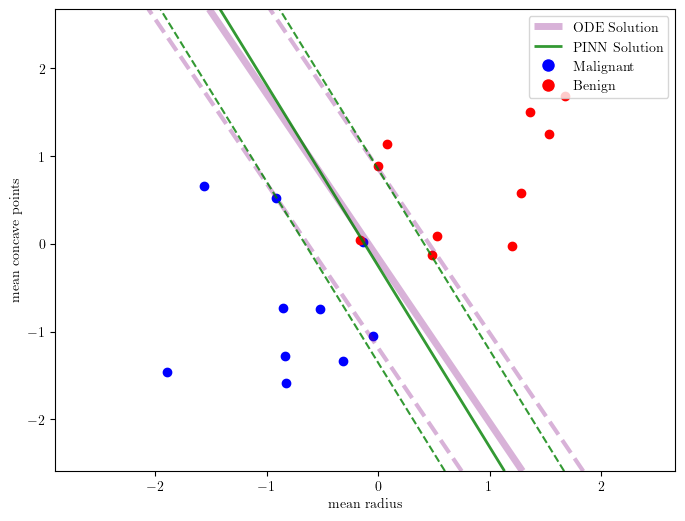

Variables: [-1.8712246  -0.9079119  -0.23449016  0.10548556 -0.02274502 -0.1755103
 -0.32681698  0.01557994 -0.02946508 -0.3516721   1.0984732   1.110479
 -0.01184344  0.1798352  -0.08414638  0.01241792 -0.14565057 -0.1006155
 -0.0519155  -0.33161697 -0.12280846  0.29805422 -0.21690214]
Constraints: [-0.52975035 -0.0023746  -0.12595478 -0.24962993 -1.5088732   0.20937736
 -0.04846564 -0.11087217 -0.07043274 -3.2227774  -2.3265476  -3.5592313
 -0.02769884 -1.305982   -1.6646826   0.02517459 -0.6966316  -3.761136
 -3.4282537  -0.8751248  -0.10548556  0.02274502  0.1755103   0.32681698
 -0.01557994  0.02946508  0.3516721  -1.0984732  -1.110479    0.01184344
 -0.1798352   0.08414638 -0.01241792  0.14565057  0.1006155   0.0519155
  0.33161697  0.12280846 -0.29805422  0.21690214]
objective pinn: 10.649057 epsion pinn: 1
w:  [-1.8712246 -0.9079119] b:  -0.23449016
PINN hyperplane similarity: 0.009032086014245683
>>>> ITERATION: 5


Time: 0.21419072151184082
objective: 22.569687 lim: 0.1
objective: 22.569687
w:  [-1.86186796 -0.99188766] b:  -0.1835493621573156
hyperplane similarity: 0.0045751816907350085
Dual variables (alpha): [-1.86186796 -0.99188766 -0.18354936  0.00000776  0.01934729  0.00001965
  0.00002812  0.00000388  0.02147621  0.00004568  0.94492112  1.08094621
  0.00003243  0.00001882  0.00001946 -0.00623725  0.00002199  0.00000199
 -0.02628435  0.00002496  0.00003667  0.00000975  0.00000894]
Constraints: [-0.5327631   0.02151608 -0.25346118 -0.73650175 -1.6436609   0.01950628
 -0.4438077  -0.00525702  0.00525093 -3.273883   -2.1320264  -3.7992473
 -0.00804283 -1.3873178  -1.9419082  -0.02420249 -1.1323663  -3.9582956
 -3.1923547  -1.0734141  -0.00000776 -0.0193473  -0.00001965 -0.00002812
 -0.00000388 -0.02147621 -0.00004568 -0.94492114 -1.0809462  -0.00003243
 -0.00001882 -0.00001946  0.00623725 -0.00002199 -0.00000199  0.02628434
 -0.00002496 -0.00003667 -0.00000975 -0.00000894]
>>> Feasible with ep

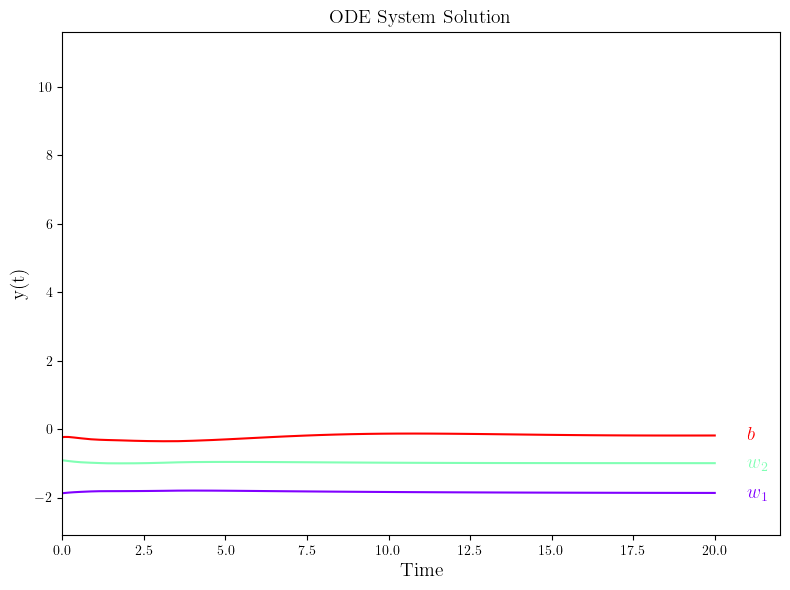

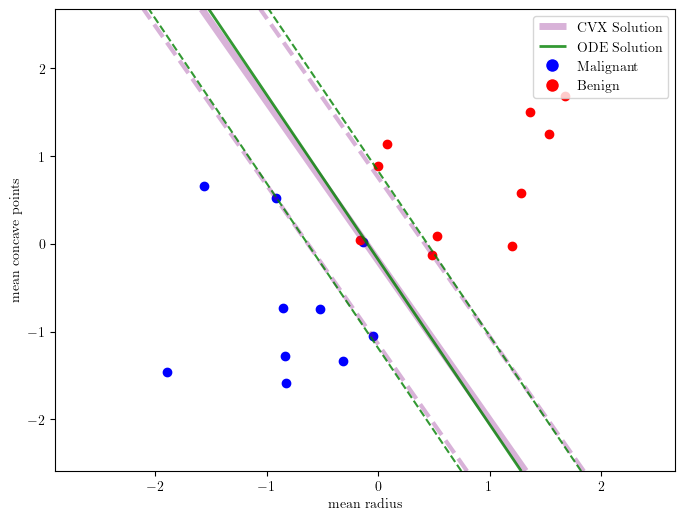

epsilon: inf time: 1149.4762670993805 iterations: 10000


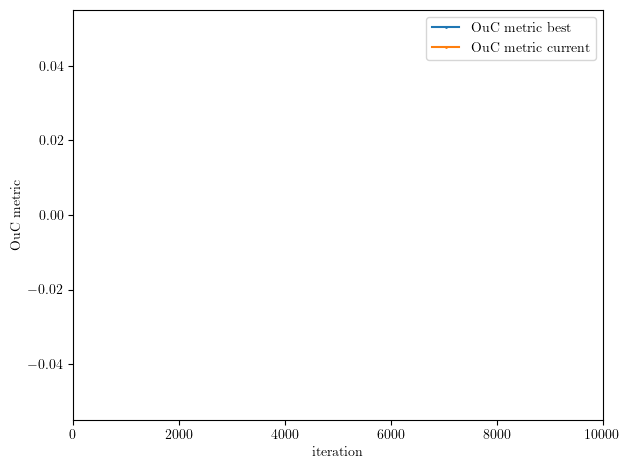

Last losses: [0.09115796536207199, 0.08451804518699646, 0.09165814518928528, 0.08013472706079483, 0.09111207723617554, 0.08687379956245422, 0.08684594929218292, 0.08242575824260712, 0.09360894560813904, 0.08283723145723343]


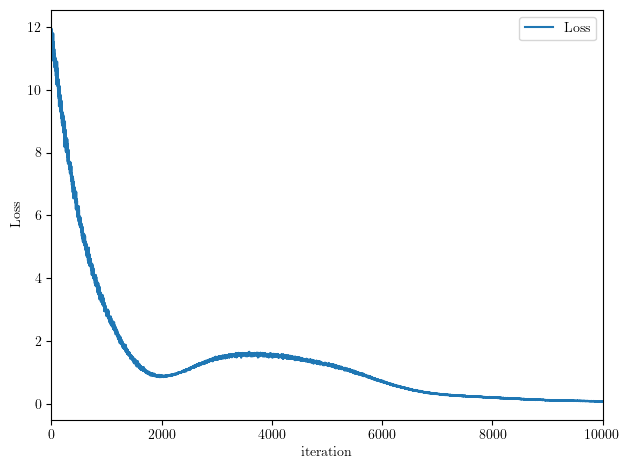

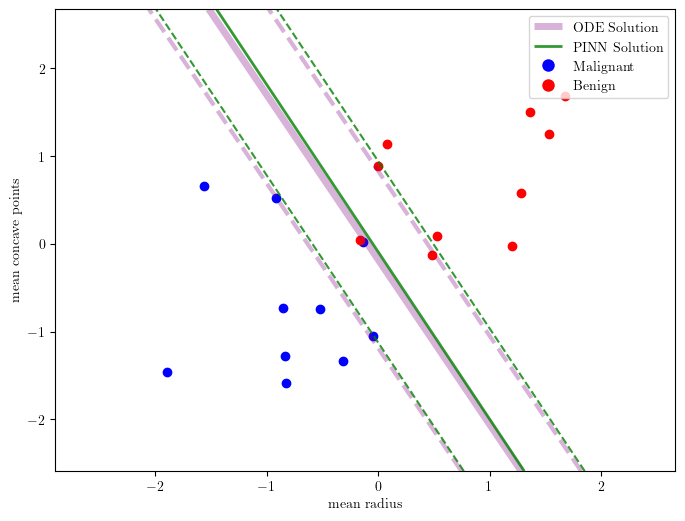

Variables: [-1.8451647  -0.9683979  -0.09421337  0.42972276  0.0566254  -0.05080049
 -0.0561631  -0.01218278 -0.00452204  0.18648374  0.7504603   1.2214108
  0.19577247  0.18352136 -0.04175279 -0.07931132 -0.03340407 -0.00077409
  0.02650221 -0.05032691  0.30692002  0.1487592   0.0095599 ]
Constraints: [-1.0255628   0.07870404 -0.10234641 -0.73294663 -1.676809   -0.01820748
 -0.5130548   0.10176407 -0.04773428 -3.3254306  -2.1913679  -3.7807949
 -0.02109084 -1.2451661  -1.9792408   0.03308916 -1.139947   -4.1085277
 -3.1939514  -1.1616026  -0.42972276 -0.0566254   0.05080049  0.0561631
  0.01218278  0.00452204 -0.18648374 -0.7504603  -1.2214108  -0.19577247
 -0.18352136  0.04175279  0.07931132  0.03340407  0.00077409 -0.02650221
  0.05032691 -0.30692002 -0.1487592  -0.0095599 ]
objective pinn: 34.036217 epsion pinn: 1
w:  [-1.8451647 -0.9683979] b:  -0.09421337
PINN hyperplane similarity: 0.0255277312616434
>>>> ITERATION: 6
Time: 0.18273115158081055
objective: 22.52135 lim: 0.1
object

Constraints: [-0.5480071   0.02381662 -0.24705394 -0.75209314 -1.6623515   0.01414739
 -0.4374155   0.00101926 -0.00102181 -3.2769456  -2.1316497  -3.825058
 -0.01402418 -1.3847833  -1.9614238  -0.02172315 -1.1496363  -3.9634035
 -3.195023   -1.0912834   0.00001671 -0.02430037 -0.0000022  -0.00000332
  0.00000038 -0.01366937  0.00000327 -0.92788553 -1.0980756   0.00000117
  0.00000195 -0.00000216  0.01450061 -0.00000227  0.00000124  0.0212398
 -0.00000445  0.00000329  0.00000046  0.00000136]
>>> Feasible with epsilon: 0.1 objective: 22.52135
hyperplane similarity: 0.0070627564214476996
>>> ODE Solution is accurate, last iteration


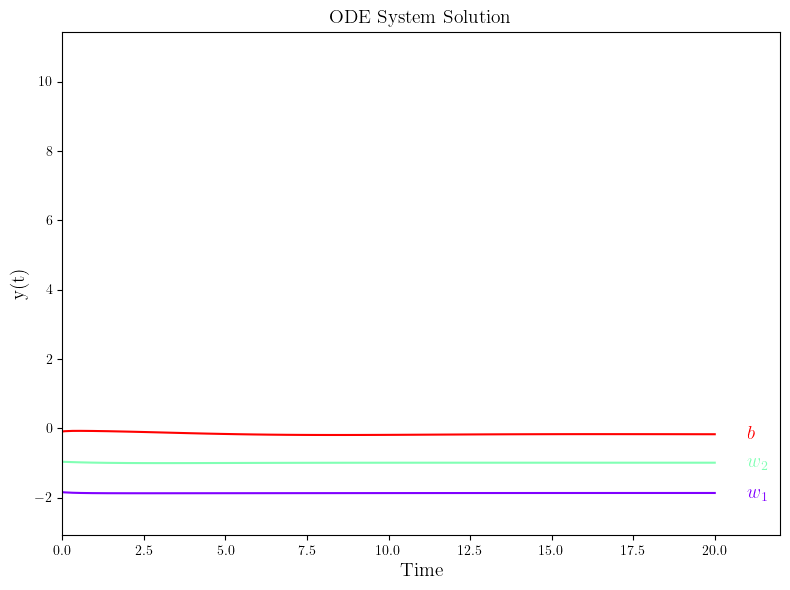

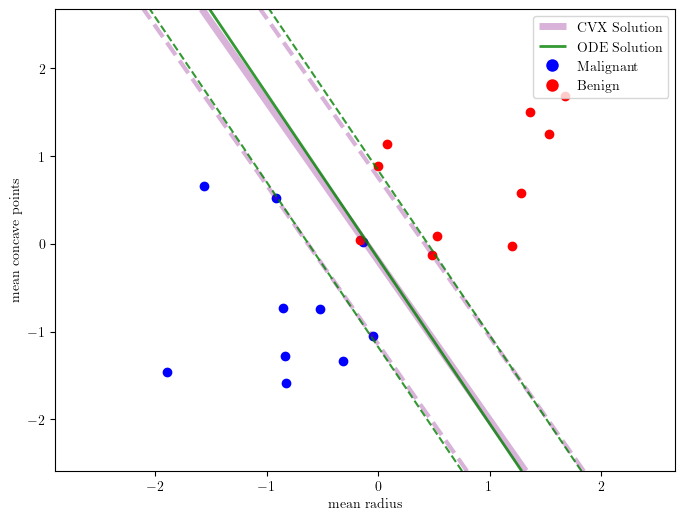

epsilon: inf time: 780.2967474460602 iterations: 7032


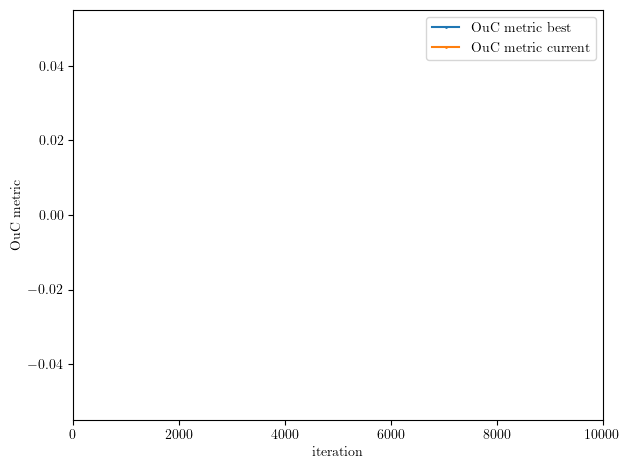

Last losses: [0.009711021557450294, 0.009856314398348331, 0.010142968967556953, 0.009798610582947731, 0.010491402819752693, 0.009527767077088356, 0.009829141199588776, 0.009940782561898232, 0.009836282581090927, 0.0095505490899086]


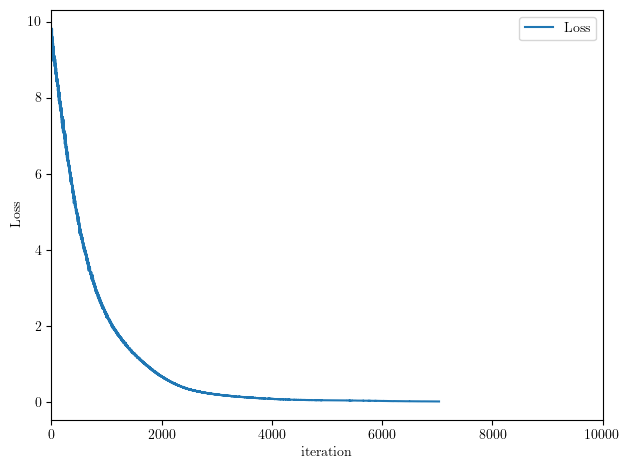

>>> NN Solution is accurate, last iteration


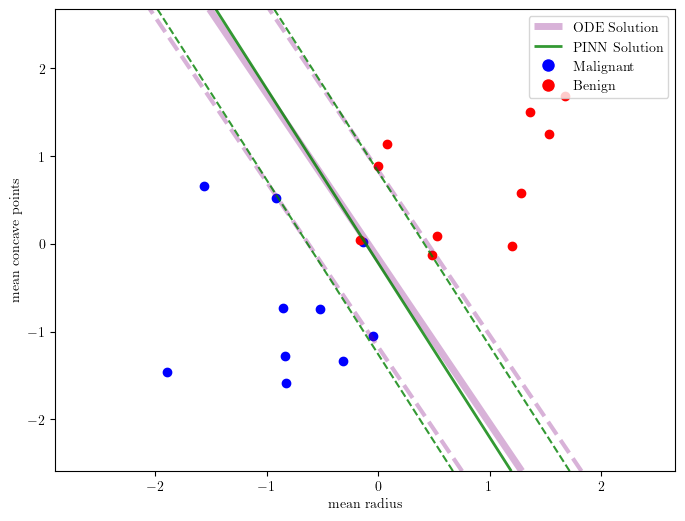

Variables: [-1.9105285  -0.9626956  -0.21572247 -0.03218395 -0.02131995 -0.03189246
  0.03478607  0.00591313  0.056733    0.05567458  0.9566306   1.0936171
  0.00962961  0.00076357 -0.01949371  0.0145233   0.02979182 -0.00000145
 -0.05672062 -0.0073099   0.04632074 -0.01275004 -0.02544853]
Constraints: [-0.4722559   0.00283537 -0.2765457  -0.7157049  -1.6208872   0.04463215
 -0.50203437  0.00773088 -0.0304154  -3.3539546  -2.2103732  -3.7972772
 -0.05638695 -1.5082946  -1.9038284   0.00037431 -1.1132442  -4.0690737
 -3.2339952  -1.1108403   0.03218395  0.02131995  0.03189246 -0.03478607
 -0.00591313 -0.056733   -0.05567458 -0.9566306  -1.0936171  -0.00962961
 -0.00076357  0.01949371 -0.0145233  -0.02979182  0.00000145  0.05672062
  0.0073099  -0.04632074  0.01275004  0.02544853]
objective pinn: 23.261076 epsion pinn: 0.1
w:  [-1.9105285 -0.9626956] b:  -0.21572247
PINN hyperplane similarity: 0.0027407593670102093
>>>> Results obtained, OuC:  23.261076


In [14]:
ITERATIONS = 2000
LR = 0.01
ip = np.zeros(NY)
ip[:nw + nb] = 1.0

for i in range(8):
    print('>>>> ITERATION:', i+1)
    res, pinn_obj, lastIter = iteration(ip)
    wb_pinn = res[:nw+1]
    if lastIter:
        print('>>>> Results obtained, OuC: ', pinn_obj)
        break
    ip = res
    ITERATIONS = 10000
    LR = 0.00001